# Predicting S&P 500 Index using Multivariate LSTM Model

In this notebook, I demonstrate how to download and process stock data from Yahoo Finance and use this data to fit a recurrent model to predict the next day closing price.
  

Load and initialize common libraries

In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from datetime import date, timedelta, datetime # Date Functions

import tensorflow as tf 
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 

import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

import yfinance as yf # convenient package for downloading stock data from yahoo finance

# for reproducibility; set the following seeds (note, that the results may still vary slightly. Also, the stock data is is up to the latest date, so the results may vary slightly over time)
np.random.seed(1)
tf.random.set_seed(1)

# you first need to install the ipympl package in your environment

Set the stock ticker symbol to analyze.

In [2]:
"""
S&P 500 : ^GSPC
DOW JONES : ^DJI
NASDAQ : ^IXIC
NYSE : ^NYA
FTSE 100 : ^FTSE
DAX : ^GDAXI
Nikkei 225 : ^N225
Hang Seng : ^HSI
Shanghai Composite : ^SSEC
Crude Oil: CL=F
Gold: GC=F
Silver: SI=F
Bitcoin: BTC-USD
Etherium: ETH-USD
USD/INR: INR=X 
USD/CAD: CADUSD=X
USD/GBP: GBPUSD=X
USD/EUR: EURUSD=X
"""

STOCK_NAME = 'S&P 500' # change this to any stock ticker you want to analyse (see yahoo finane for a list of tickers)
STOCK_SYMBOL = '^GSPC' # change this to any stock ticker you want to analyse (see yahoo finane for a list of tickers)
years = 20 # number of years of data to download
sequence_length = 90 # number of days to use for prediction

## Load the Time Series Data

In [3]:
# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365*years)).strftime("%Y-%m-%d")
print("Date range", start_date, "to", end_date)

# Get stock quote data
stockname = STOCK_NAME
symbol = STOCK_SYMBOL

# Use yahoo finance to download the stock data
df = yf.download(symbol, start=start_date, end=end_date)

# View the first 5 rows of the data
df.head()

Date range 2003-05-03 to 2023-04-28
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-05-05,930.080017,933.880005,924.549988,926.549988,926.549988,1446300000
2003-05-06,926.549988,939.609985,926.380005,934.390015,934.390015,1649600000
2003-05-07,934.390015,937.219971,926.409973,929.619995,929.619995,1531900000
2003-05-08,929.619995,929.619995,919.719971,920.270020,920.270020,1379600000
2003-05-09,920.270020,933.770020,920.270020,933.409973,933.409973,1326100000


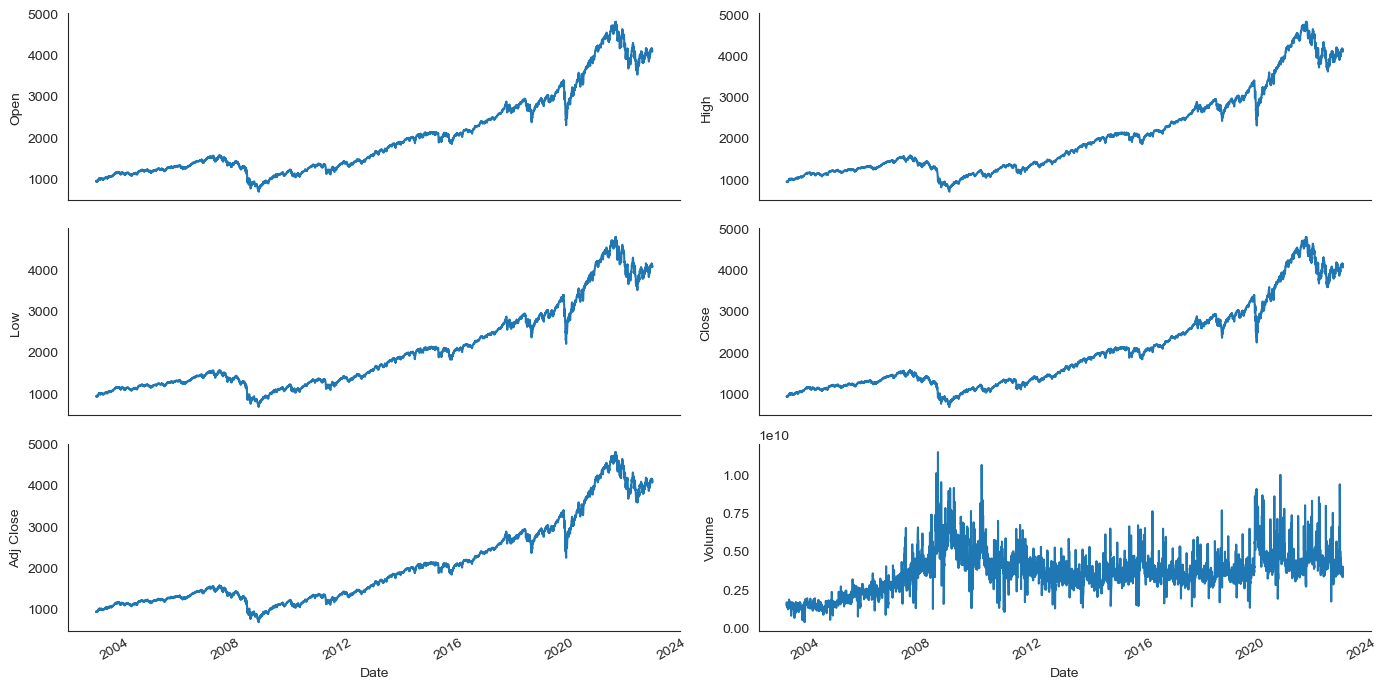

In [4]:
ncols = 2
nrows = math.ceil(df.shape[1] / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7)) # sharex allows for all subplots to have the same x-axis
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)  # plot the i-th column of the dataframe
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator()) # AutoDateFormatter class figures out the best format to use for the date
fig.tight_layout()
plt.show()

In [5]:
#train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = [
    'High', 'Low', 'Open', 'Close', 'Volume'
    #, 'Month', 'Year', 'Adj Close' # these are also possible features
]

# Create the dataset with features and filter the data to the list of FEATURES
df = df[FEATURES]

# df['Date'] = df.index # may add this later to include dates as x-axis in final plot

# Print the tail of the dataframe
df.head()

,High,Low,Open,Close,Volume
Date,,,,,
2003-05-05,933.880005,924.549988,930.080017,926.549988,1446300000
2003-05-06,939.609985,926.380005,926.549988,934.390015,1649600000
2003-05-07,937.219971,926.409973,934.390015,929.619995,1531900000
2003-05-08,929.619995,919.719971,929.619995,920.270020,1379600000
2003-05-09,933.770020,920.270020,920.270020,933.409973,1326100000


In [6]:
df.to_numpy()

array([[9.33880005e+02, 9.24549988e+02, 9.30080017e+02, 9.26549988e+02,
        1.44630000e+09],
       [9.39609985e+02, 9.26380005e+02, 9.26549988e+02, 9.34390015e+02,
        1.64960000e+09],
       [9.37219971e+02, 9.26409973e+02, 9.34390015e+02, 9.29619995e+02,
        1.53190000e+09],
       ...,
       [4.12643018e+03, 4.07137988e+03, 4.12643018e+03, 4.07162988e+03,
        3.97864000e+09],
       [4.08966992e+03, 4.04935010e+03, 4.08778003e+03, 4.05598999e+03,
        3.83703000e+09],
       [4.13824023e+03, 4.07529004e+03, 4.07529004e+03, 4.13535010e+03,
        3.75055000e+09]])

## Scaling the Multivariate Data

In [7]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler_features = MinMaxScaler()
np_data = scaler_features.fit_transform(df[FEATURES])
np_data

array([[0.05786799, 0.06266578, 0.06079661, 0.06068401, 0.0982175 ],
       [0.05925763, 0.06311068, 0.05994089, 0.06258692, 0.11653255],
       [0.058678  , 0.06311797, 0.0618414 , 0.06142916, 0.1059291 ],
       ...,
       [0.83212923, 0.82771284, 0.83562622, 0.82404736, 0.32635295],
       [0.82321409, 0.82235703, 0.82625701, 0.82025129, 0.31359548],
       [0.83499342, 0.82866347, 0.82322931, 0.83951332, 0.3058046 ]])

In [8]:
# We need to save a specfic scaler for prediction data (to 'unscale' the values later)
scaler_pred = MinMaxScaler()

_ = scaler_pred.fit(pd.DataFrame(df['Close']))

## Transforming the Multivariate Data

In [9]:
np_data

array([[0.05786799, 0.06266578, 0.06079661, 0.06068401, 0.0982175 ],
       [0.05925763, 0.06311068, 0.05994089, 0.06258692, 0.11653255],
       [0.058678  , 0.06311797, 0.0618414 , 0.06142916, 0.1059291 ],
       ...,
       [0.83212923, 0.82771284, 0.83562622, 0.82404736, 0.32635295],
       [0.82321409, 0.82235703, 0.82625701, 0.82025129, 0.31359548],
       [0.83499342, 0.82866347, 0.82322931, 0.83951332, 0.3058046 ]])

In [10]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features

index_Close = df.columns.get_loc("Close") # returns the index of the Close column
print("Index Close: " + str(index_Close))

def partition_dataset(sequence_length, data):
    x, y = [],[]
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    x = np.delete(x, index_Close, 2) #delete the Close column in the 3d array (delete index_Close column in the 2nd dimension)
    y = np.array(y)
    return x, y

# Generate training data and test data
X, y = partition_dataset(sequence_length, np_data)

Index Close: 3


In [11]:
X

array([[[0.05786799, 0.06266578, 0.06079661, 0.0982175 ],
        [0.05925763, 0.06311068, 0.05994089, 0.11653255],
        [0.058678  , 0.06311797, 0.0618414 , 0.1059291 ],
        ...,
        [0.08176362, 0.08620921, 0.08293114, 0.08497445],
        [0.08157687, 0.08614843, 0.08541585, 0.09537971],
        [0.07952271, 0.08337689, 0.08336262, 0.11045156]],

       [[0.05925763, 0.06311068, 0.05994089, 0.11653255],
        [0.058678  , 0.06311797, 0.0618414 , 0.1059291 ],
        [0.05683485, 0.06149152, 0.0606851 , 0.09220858],
        ...,
        [0.08157687, 0.08614843, 0.08541585, 0.09537971],
        [0.07952271, 0.08337689, 0.08336262, 0.11045156],
        [0.07896734, 0.08366377, 0.08039309, 0.0882717 ]],

       [[0.058678  , 0.06311797, 0.0618414 , 0.1059291 ],
        [0.05683485, 0.06149152, 0.0606851 , 0.09220858],
        [0.05784132, 0.06162524, 0.05841856, 0.08738883],
        ...,
        [0.07952271, 0.08337689, 0.08336262, 0.11045156],
        [0.07896734, 0.083663

In [12]:
arr = [[0,1,2,3],[4,5,6,7], [8,9,10,11]]
arr

[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]]

In [13]:
arr = np.array(arr, dtype=np.double)
arr

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

In [14]:
np.column_stack((arr, [79,89,99]))

array([[ 0.,  1.,  2.,  3., 79.],
       [ 4.,  5.,  6.,  7., 89.],
       [ 8.,  9., 10., 11., 99.]])

In [15]:
np.row_stack((arr, [79,89,99,109]))

array([[  0.,   1.,   2.,   3.],
       [  4.,   5.,   6.,   7.],
       [  8.,   9.,  10.,  11.],
       [ 79.,  89.,  99., 109.]])

In [16]:
np.delete(arr, 1, 1)

array([[ 0.,  2.,  3.],
       [ 4.,  6.,  7.],
       [ 8., 10., 11.]])

But, what about 3 dimensional data (which is used in developing RNNs)? 

In [17]:
arr = [
    [[0,1,2,3],[4,5,6,7], [8,9,10,11]],
    [[12,13,14,15],[16,17,18,19], [20,21,22,23]]
]
arr


[[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]],
 [[12, 13, 14, 15], [16, 17, 18, 19], [20, 21, 22, 23]]]

In [18]:
np.delete(arr, 1, 2) # delete the column index 1 in the 2nd dimension

array([[[ 0,  2,  3],
        [ 4,  6,  7],
        [ 8, 10, 11]],

       [[12, 14, 15],
        [16, 18, 19],
        [20, 22, 23]]])

In [19]:
np.delete(arr, 1, 1) # delete the row index 1 in the 1st dimension (this will delete the 2nd row of each 2d array in the 3d array)

# note: I can't delete a row in just one 2d array in the 3d array - this will result in the array being unbalanced

array([[[ 0,  1,  2,  3],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [20, 21, 22, 23]]])

In [20]:
np.delete(arr, 0,0) # delete the row index 1 in the 1st dimension (this will delete the 1st 2d array in the 3d array)

array([[[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [21]:
X

array([[[0.05786799, 0.06266578, 0.06079661, 0.0982175 ],
        [0.05925763, 0.06311068, 0.05994089, 0.11653255],
        [0.058678  , 0.06311797, 0.0618414 , 0.1059291 ],
        ...,
        [0.08176362, 0.08620921, 0.08293114, 0.08497445],
        [0.08157687, 0.08614843, 0.08541585, 0.09537971],
        [0.07952271, 0.08337689, 0.08336262, 0.11045156]],

       [[0.05925763, 0.06311068, 0.05994089, 0.11653255],
        [0.058678  , 0.06311797, 0.0618414 , 0.1059291 ],
        [0.05683485, 0.06149152, 0.0606851 , 0.09220858],
        ...,
        [0.08157687, 0.08614843, 0.08541585, 0.09537971],
        [0.07952271, 0.08337689, 0.08336262, 0.11045156],
        [0.07896734, 0.08366377, 0.08039309, 0.0882717 ]],

       [[0.058678  , 0.06311797, 0.0618414 , 0.1059291 ],
        [0.05683485, 0.06149152, 0.0606851 , 0.09220858],
        [0.05784132, 0.06162524, 0.05841856, 0.08738883],
        ...,
        [0.07952271, 0.08337689, 0.08336262, 0.11045156],
        [0.07896734, 0.083663

In [22]:
from sklearn.model_selection import train_test_split

# Prediction Index
index_Close = df.columns.get_loc("Close") # returns the index of the Close column
print("Index Close: " + str(index_Close))

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, shuffle=False)

Index Close: 3


In [23]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(X_train[1][sequence_length-1][index_Close])
print(y_train[0])

(3952, 90, 4) (3952,)
(989, 90, 4) (989,)
0.08827170058809963
0.08249696026397335


In [24]:
## Train the Multivariate Prediction Model

In [25]:
from keras.optimizers import Adam
import tensorflow as tf

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False )) 
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation=None))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mse'
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 42,511
Trainable params: 42,511
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Training the model
epochs = 100 # should be at least 50, but it takes a long time to train. 
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(
        X_train, y_train, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[early_stop]
)

Epoch 1/100


2023-04-28 16:03:00.512573: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


247/247 [==============================] - 6s 22ms/step - loss: 0.0022 - val_loss: 7.1505e-04
Epoch 2/100
247/247 [==============================] - 5s 22ms/step - loss: 5.4295e-05 - val_loss: 0.0012
Epoch 3/100
247/247 [==============================] - 5s 22ms/step - loss: 6.2534e-05 - val_loss: 4.4522e-04
Epoch 4/100
247/247 [==============================] - 5s 22ms/step - loss: 5.1353e-05 - val_loss: 2.9261e-04
Epoch 5/100
247/247 [==============================] - 5s 22ms/step - loss: 4.2584e-05 - val_loss: 2.8478e-04
Epoch 6/100
247/247 [==============================] - 5s 21ms/step - loss: 4.4569e-05 - val_loss: 2.6443e-04
Epoch 7/100
247/247 [==============================] - 5s 21ms/step - loss: 4.5553e-05 - val_loss: 2.2167e-04
Epoch 8/100
247/247 [==============================] - 5s 21ms/step - loss: 4.3543e-05 - val_loss: 3.2343e-04
Epoch 9/100
247/247 [==============================] - 5s 21ms/step - loss: 3.4576e-05 - val_loss: 2.2135e-04
Epoch 10/100
247/247 [========

Let's look at the loss curve

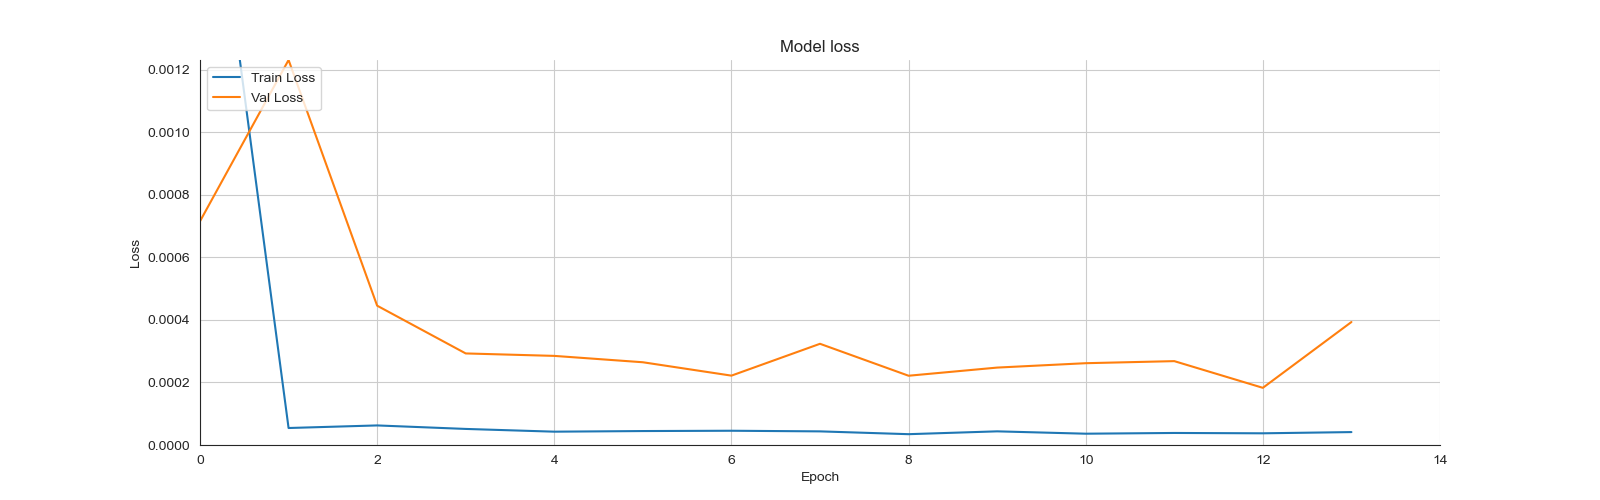

In [27]:
%matplotlib widget
# This amagic will allow you to zoom and move the plot around.
# You may need to install the ipympl package in your environment.
# From your terminal (or in windows, anaconda prompt) type the following
#  conda install ipympl 
# (be sure to activate your tensorflow environment first)

plt.subplots(figsize=(16, 5), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xlim(0, len(history.history['loss'])) # set the x-axis from 0 to the number of completed epochs
plt.ylim(0, max(history.history["val_loss"])) # set the y-axis from 0 to the maximum validation loss
plt.legend(["Train Loss", "Val Loss"], loc="upper left")
plt.grid()
plt.show()

## Evaluate model performance

In [28]:
# Get the predicted values
y_pred = model.predict(X_test)

# Unscale the predicted values
y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

31/31 [==============================] - 0s 8ms/step
Median Absolute Error (MAE): 68.95
Mean Absolute Percentage Error (MAPE): 1.85 %
Median Absolute Percentage Error (MDAPE): 1.72 %


In [29]:
%matplotlib widget

# The date from which on the date is displayed
display_start_date = "2010-01-01" 

X, y = partition_dataset(sequence_length, np_data)

y_pred = model.predict(X)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
y_unscaled = scaler_pred.inverse_transform(y.reshape(-1, 1))
residuals = y_pred_unscaled - y_unscaled

results = pd.DataFrame({'Date':df[sequence_length:].index, 'Close':y_unscaled[:,0], 'Prediction':y_pred_unscaled[:,0], 'Residuals': y_pred_unscaled[:,0] - y_unscaled[:,0]})



155/155 [==============================] - 1s 8ms/step


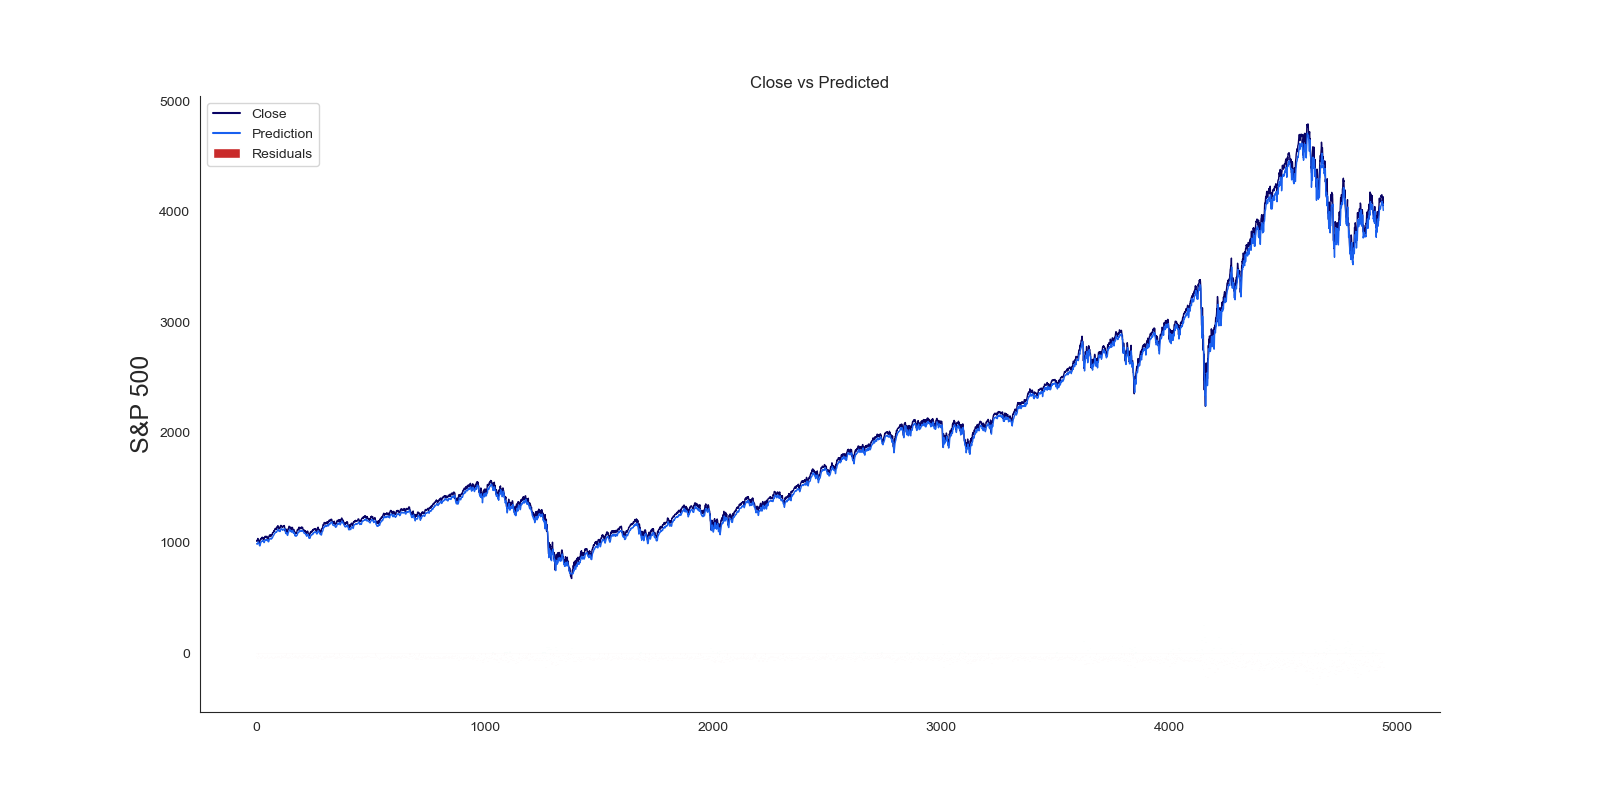

In [30]:
# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Close vs Predicted")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF"])
sns.lineplot(data=results[['Close', 'Prediction']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
# note: I need to separate this from the close versus predicted plot - otherwise, it can be too small to read
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in results["Residuals"].dropna()]
ax1.bar(height=results['Residuals'].dropna(), x=results['Residuals'].dropna().index, width=3, label='Residuals', color=df_sub)
plt.legend()
plt.show()

**NOTE** -- use your mouse to zoom into the chart above... it's difficult to see the predicted versus actual when viewing the entire time series.